In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['PROJ_LIB'] = r'C:/Users/mastr/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Windows OS
# os.environ['PROJ_LIB'] = r'/Users/mmastro/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Mac OS
import glob
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
#from scipy.signal import argrelextrema                      # Find local Maxima-Minima in numpy array
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

Functions declaration

In [2]:
def detrend_dim(da, dim, degree):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=degree)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    da_det = (da - fit)
    return da_det

def xr_mean_list(xr_list, esm):
    ## Function for calculate the mean response of several simulations from different ESM
    # xr_list: list of xarray, each representing one simulation 
    # nc_files: list of NetCDF opened with nc.Dataset(), containing data and attributes
    # returns an xr_list_new with one element for each esm 

    # List of ESM names in every simulation
    # esm = [a.source_id for a in nc_files]
    # esm = [nc_files]#

    # Assign as a new coordinate ESM name
    xr_list = [a.assign_coords(esm=b) for a,b in zip(xr_list,esm)]

    # List of unique ESM names sorted
    esm = list(set(esm))
    esm.sort()

    # Create a list of the different esm lists
    access = []; bcc = []; cesm = []; cmcc = []; cnrm = []; canesm = []; e3sm = []; ipsl = []; miroc = []; mpi = []; noresm = []; taiesm = []; ukesm = []
    esm_list = [access, bcc, cesm, cmcc, cnrm, canesm, e3sm, ipsl, miroc, mpi, noresm, taiesm, ukesm]

    # populate the esm_list according to xr.coords["esm"]
    for e,model in enumerate(esm):
        for i,xarray in enumerate(xr_list):
            esm_coord = xarray.coords["esm"]
            if esm_coord == esm[e]:
                esm_list[e].append(xarray)

    # take the mean of all the xarray belonging to the same esm
    xr_list_new = []
    for e in esm_list:
        content = xr.concat(e, dim='realiz')
        content1 = content.mean(dim = "realiz")
        xr_list_new.append(content1)
    
    return xr_list_new

## Fuction for subsetting colormap values ## 
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## Function for creating a path, if needed ##
def checkDir(out_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope
    y_pred =  intercept + slope*x
    res = y - y_pred

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    #return cov,cor,slope,intercept,pval,stderr
    return res

def cor_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)

    #return cov,cor,slope,intercept,pval,stderr
    return cor

def xr_multipletest(p, alpha=0.05, method='fdr_bh', **multipletests_kwargs):
    """Apply statsmodels.stats.multitest.multipletests for multi-dimensional xr.objects."""
    from statsmodels.stats.multitest import multipletests
    # stack all to 1d array
    p_stacked = p.stack(s=p.dims)
    # mask only where not nan: https://github.com/statsmodels/statsmodels/issues/2899
    mask = np.isfinite(p_stacked)
    pvals_corrected = np.full(p_stacked.shape, np.nan)
    reject = np.full(p_stacked.shape, np.nan)
    # apply test where mask
    reject[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[0]
    pvals_corrected[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[1]

    def unstack(reject, p_stacked):
        """Exchange values from p_stacked with reject (1d array) and unstack."""
        xreject = p_stacked.copy()
        xreject.values = reject
        xreject = xreject.unstack()
        return xreject

    reject = unstack(reject, p_stacked)
    pvals_corrected = unstack(pvals_corrected, p_stacked)
    return reject, pvals_corrected


In [3]:
# -- Path for the output files (images, etc)
# out_path = 'C:/Users/mastr/Documents/Amazon/RESULTS/'
out_path = 'G:/Shared drives/Amazon_ENSO_work/RESULTS/MLR/'

#out_path = "D:/Data/CMIP6/RESULTS"

# -- Create directories
checkDir(out_path)

## Open LAND data

In [4]:
data_path = 'F:/Data/analysis/'              

scenario = 'historical'
var_name = 'nep'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    ds_hist_nep.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_nep.append(content)    

# Subsetting latitude
ds_hist_nep = [a.sel(lat=slice(-30,30)) for a in ds_hist_nep]
ds_ssp_nep = [a.sel(lat=slice(-30,30)) for a in ds_ssp_nep]

# Uniform calendar
for i, item in enumerate(ds_hist_nep):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_nep[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_nep):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_nep[i]['time'] = item.indexes['time'].to_datetimeindex()

# Resample from months to seasons
ds_hist_nep = [a.resample(time="QS", label='left').mean() for a in ds_hist_nep]
ds_ssp_nep = [a.resample(time="QS", label='left').mean() for a in ds_ssp_nep]

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_hist_nep[i] = ds_hist_nep[i].where(ds_hist_nep[i] != -3.7270379e-07)
        ds_ssp_nep[i] = ds_ssp_nep[i].where(ds_ssp_nep[i] != -6.18386321e-06)

# Correct for inverse NEP value in CESM2
esm = []
for filepath in sorted(glob.glob(os.path.join('F:/Data/analysis/'+'/'+'historical'+'/'+'nep' + '_*_' + 'historical' + '_*'))):     
        content = nc.Dataset(filepath).source_id
        esm.append(content)   

for i,model in enumerate(esm):
        if model == "CESM2-WACCM":
                ds_hist_nep[i] = ds_hist_nep[i]*-1
                ds_ssp_nep[i] = ds_ssp_nep[i]*-1
        else:
                None

In [5]:
data_path = 'F:/Data/analysis/'              

scenario = 'historical'
var_name = 'gpp'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_gpp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    ds_hist_gpp.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_gpp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_gpp.append(content)    

# Subsetting latitude
ds_hist_gpp = [a.sel(lat=slice(-30,30)) for a in ds_hist_gpp]
ds_ssp_gpp = [a.sel(lat=slice(-30,30)) for a in ds_ssp_gpp]

# Uniform calendar
for i, item in enumerate(ds_hist_gpp):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_gpp[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_gpp):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_gpp[i]['time'] = item.indexes['time'].to_datetimeindex()

# Resample from months to seasons
ds_hist_gpp = [a.resample(time="QS", label='left').mean() for a in ds_hist_gpp]
ds_ssp_gpp = [a.resample(time="QS", label='left').mean() for a in ds_ssp_gpp]

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_hist_gpp[i] = ds_hist_gpp[i].where(ds_hist_gpp[i] != -3.7270379e-07)
        ds_ssp_gpp[i] = ds_ssp_gpp[i].where(ds_ssp_gpp[i] != -6.18386321e-06)

# Correct for inverse gpp value in CESM2
esm = []
for filepath in sorted(glob.glob(os.path.join('F:/Data/analysis/'+'/'+'historical'+'/'+'gpp' + '_*_' + 'historical' + '_*'))):     
        content = nc.Dataset(filepath).source_id
        esm.append(content)   

for i,model in enumerate(esm):
        if model == "CESM2-WACCM":
                ds_hist_gpp[i] = ds_hist_gpp[i]*-1
                ds_ssp_gpp[i] = ds_ssp_gpp[i]*-1
        else:
                None

In [6]:
data_path = 'F:/Data/analysis/'              

scenario = 'historical'
var_name = 'rh'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_rh = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    ds_hist_rh.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_rh = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_rh.append(content)    

# Subsetting latitude
ds_hist_rh = [a.sel(lat=slice(-30,30)) for a in ds_hist_rh]
ds_ssp_rh = [a.sel(lat=slice(-30,30)) for a in ds_ssp_rh]

# Uniform calendar
for i, item in enumerate(ds_hist_rh):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_rh[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_rh):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_rh[i]['time'] = item.indexes['time'].to_datetimeindex()

# Resample from months to seasons
ds_hist_rh = [a.resample(time="QS", label='left').mean() for a in ds_hist_rh]
ds_ssp_rh = [a.resample(time="QS", label='left').mean() for a in ds_ssp_rh]

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_hist_rh[i] = ds_hist_rh[i].where(ds_hist_rh[i] != -3.7270379e-07)
        ds_ssp_rh[i] = ds_ssp_rh[i].where(ds_ssp_rh[i] != -6.18386321e-06)

# Correct for inverse rh value in CESM2
esm = []
for filepath in sorted(glob.glob(os.path.join('F:/Data/analysis/'+'/'+'historical'+'/'+'rh' + '_*_' + 'historical' + '_*'))):     
        content = nc.Dataset(filepath).source_id
        esm.append(content)   

for i,model in enumerate(esm):
        if model == "CESM2-WACCM":
                ds_hist_rh[i] = ds_hist_rh[i]*-1
                ds_ssp_rh[i] = ds_ssp_rh[i]*-1
        else:
                None

In [7]:
data_path = 'F:/Data/analysis/'              

scenario = 'historical'
var_name = 'ra'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_ra = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    ds_hist_ra.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_ra = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_ra.append(content)    

# Subsetting latitude
ds_hist_ra = [a.sel(lat=slice(-30,30)) for a in ds_hist_ra]
ds_ssp_ra = [a.sel(lat=slice(-30,30)) for a in ds_ssp_ra]

# Uniform calendar
for i, item in enumerate(ds_hist_ra):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_ra[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_ra):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_ra[i]['time'] = item.indexes['time'].to_datetimeindex()

# Resample from months to seasons
ds_hist_ra = [a.resample(time="QS", label='left').mean() for a in ds_hist_ra]
ds_ssp_ra = [a.resample(time="QS", label='left').mean() for a in ds_ssp_ra]

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_hist_ra[i] = ds_hist_ra[i].where(ds_hist_ra[i] != -3.7270379e-07)
        ds_ssp_ra[i] = ds_ssp_ra[i].where(ds_ssp_ra[i] != -6.18386321e-06)

# Correct for inverse ra value in CESM2
esm = []
for filepath in sorted(glob.glob(os.path.join('F:/Data/analysis/'+'/'+'historical'+'/'+'ra' + '_*_' + 'historical' + '_*'))):     
        content = nc.Dataset(filepath).source_id
        esm.append(content)   

for i,model in enumerate(esm):
        if model == "CESM2-WACCM":
                ds_hist_ra[i] = ds_hist_ra[i]*-1
                ds_ssp_ra[i] = ds_ssp_ra[i]*-1
        else:
                None

## Correct for lon lat mishape and values

In [8]:
# Correct the number of longitude points
ds_hist_gpp = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_gpp, ds_hist_nep)]
ds_hist_rh = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_rh, ds_hist_nep)]
ds_hist_ra = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_ra, ds_hist_nep)]

ds_ssp_gpp = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_gpp, ds_ssp_nep)]
ds_ssp_rh = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_rh, ds_ssp_nep)]
ds_ssp_ra = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_ra, ds_ssp_nep)]

# Assign the exactly same set of coordinates to ALL the dataarray (avoid duplication due to numerical approximation of lon lat)
ds_hist_gpp = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_gpp,ds_hist_nep)]
ds_hist_rh = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_rh,ds_hist_nep)]
ds_hist_ra = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_ra,ds_hist_nep)]

ds_ssp_gpp = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_gpp,ds_ssp_nep)]
ds_ssp_rh = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_rh,ds_ssp_nep)]
ds_ssp_ra = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_ra,ds_ssp_nep)]


# Trends of NEP/precipitation in Amazon

In [10]:
# Zonal mean of REAN and ESM

import json
import os
import glob
import geopandas as gpd
from importlib.machinery import SourceFileLoader
# imports the module from the given path
gpd = SourceFileLoader("geopandas","C:/Users/mastr/miniconda3/pkgs/geopandas-0.7.0-py_1/site-packages/geopandas/__init__.py").load_module()
import regionmask

def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

def mask_shape(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    ds_m = ds.where(mask)
    return ds_m

def zonal_stat(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    # Apply mask to xarray
    ds_m = ds.where(mask)
    # Calculate cell area of the xarray
    cell_area = cell_weight(ds)
    # Zonal statistic for all the regions
    ds_z = ds_m.weighted(cell_area).mean(["lat","lon"])
    # ds_z = ds_z.groupby("region").mean(])
    return ds_z

# geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/amazon_border/biome.shp')))
geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')))

### Regional Trends

In [ ]:
## ====== Choose what to plot ===== ##
var_name = "nep"

AMZ = ("lat = slice(-15,10), lon = slice(280,310)")
NEA = ("lat = slice(-10,10), lon = slice(300,310)")
SEA = ("lat = slice(-15,10), lon = slice(300,310)")
WA = ("lat = slice(-15,10), lon = slice(280,300)")
CER = ("lat = slice(-130,10), lon = slice(300,320)")

## ======== Concatenate hist and SSP data ======= ##

if var_name == "nep":
    DS_models = []
    for i, item in enumerate(esm):
        content = xr.concat([DS_models_hist[i],DS_models_ssp[i]], dim = "time")
        DS_models.append(content)

if var_name == "pr":
    DS_models = []
    for i, item in enumerate(esm):
        content = xr.concat([DS_models_hist_pr[i],DS_models_ssp_pr[i]], dim = "time")
        DS_models.append(content)

if var_name == "mrso":
    DS_models = []
    for i, item in enumerate(esm):
        content = xr.concat([DS_models_hist_mrso[i],DS_models_ssp_mrso[i]], dim = "time")
        DS_models.append(content)

if var_name == "tas":
    DS_models = []
    for i, item in enumerate(esm):
        content = xr.concat([DS_models_hist_tas[i],DS_models_ssp_tas[i]], dim = "time")
        DS_models.append(content)
    
## ======= Trend wrt 1850-1910 climatology ======= ##

amz_trend = []
for i, item in enumerate(esm):
    DS_models[i] = DS_models[i].assign_coords(lat = cell_area[i].lat); DS_models[i] = DS_models[i].assign_coords(lon = cell_area[i].lon)
    content = (DS_models[i].sel(lat = slice(-15,10), lon = slice(280,310)).weighted(cell_area[i]).mean(["lat", "lon"]) - 
    DS_models[i].sel(lat = slice(-15,10), lon = slice(280,310)).sel(time= slice("1901-01", "1960-12")).mean('time').weighted(cell_area[i]).mean(["lat", "lon"])).compute(dim=var_name)
    amz_trend.append(content)

nea_trend = []
for i, item in enumerate(esm):
    DS_models[i] = DS_models[i].assign_coords(lat = cell_area[i].lat); DS_models[i] = DS_models[i].assign_coords(lon = cell_area[i].lon)
    content = (DS_models[i].sel(lat = slice(-10,10), lon = slice(300,310)).weighted(cell_area[i]).mean(["lat", "lon"]) - 
    DS_models[i].sel(lat = slice(-10,10), lon = slice(300,310)).sel(time= slice("1901-01", "1960-12")).mean('time').weighted(cell_area[i]).mean(["lat", "lon"])).compute(dim=var_name)
    nea_trend.append(content)

sea_trend = []
for i, item in enumerate(esm):
    DS_models[i] = DS_models[i].assign_coords(lat = cell_area[i].lat); DS_models[i] = DS_models[i].assign_coords(lon = cell_area[i].lon)
    content = (DS_models[i].sel(lat = slice(-15,10), lon = slice(300,310)).weighted(cell_area[i]).mean(["lat", "lon"]) - 
    DS_models[i].sel(lat = slice(-15,10), lon = slice(300,310)).sel(time= slice("1901-01", "1960-12")).mean('time').weighted(cell_area[i]).mean(["lat", "lon"])).compute(dim=var_name)
    sea_trend.append(content)

wa_trend = []
for i, item in enumerate(esm):
    DS_models[i] = DS_models[i].assign_coords(lat = cell_area[i].lat); DS_models[i] = DS_models[i].assign_coords(lon = cell_area[i].lon)
    content = (DS_models[i].sel(lat = slice(-15,10), lon = slice(280,300)).weighted(cell_area[i]).mean(["lat", "lon"]) - 
    DS_models[i].sel(lat = slice(-15,10), lon = slice(280,300)).sel(time= slice("1901-01", "1960-12")).mean('time').weighted(cell_area[i]).mean(["lat", "lon"])).compute(dim=var_name)
    wa_trend.append(content)

cer_trend = []
for i, item in enumerate(esm):
    DS_models[i] = DS_models[i].assign_coords(lat = cell_area[i].lat); DS_models[i] = DS_models[i].assign_coords(lon = cell_area[i].lon)
    content = (DS_models[i].sel(lat = slice(-130,10), lon = slice(300,320)).weighted(cell_area[i]).mean(["lat", "lon"]) - 
    DS_models[i].sel(lat = slice(-130,10), lon = slice(300,320)).sel(time= slice("1901-01", "1960-12")).mean('time').weighted(cell_area[i]).mean(["lat", "lon"])).compute(dim=var_name)
    cer_trend.append(content)

regions = [nea_trend, sea_trend, wa_trend, cer_trend]
titles = ["North-Eastern Amazon", "South-Eastern Amazon", "Western Amazon", "Cerrado"]


## ======== MULTIPLE Plots ======= ##
width_inch = 10; height_inch = 8

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(width_inch, height_inch))
axs = axs.ravel()

for r, ax in enumerate(regions):

    ## ======== Spurious values of temperature in kelvin
    if var_name == "tas":
        regions[r][5] = regions[r][5].where(regions[r][5]>-50, -0.5)

    axs[r].set_prop_cycle(color=[
        '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
        '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
        '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
        '#17becf', '#9edae5'])

    for i, item in enumerate(esm):
        axs[r].plot(regions[r][i]["time"], regions[r][i].rolling(time = 84, center = True).mean(), )  # fill with colorlabels =files_list)
        # ax.label_outer()

    if var_name == "nep":
        axs[r].set_ylim(-220, 220)
        fig.legend(esm, loc='upper right',bbox_to_anchor=(0.35, 0.22), fontsize=8, ncol= 2)
        axs[r].set_xlabel("years")
        axs[r].set_ylabel("gCm$^{-2}$y$^{-1}$")
        fig.suptitle = "Amazon NEP trend"
        axs[r].set_title(titles[r])
        output_file = os.path.join(out_path, "Amazon NEP trend".replace('/','_')) + ".png"

    if var_name == "pr":
        axs[r].set_ylim(-80, 80)
        fig.legend(esm, loc='upper right',bbox_to_anchor=(0.56, 0.88), fontsize=8, ncol= 2)
        axs[r].set_xlabel("years")
        axs[r].set_ylabel("mm month$^{-1}$")
        fig.suptitle = "Amazon precipitation trend"
        axs[r].set_title(titles[r])
        output_file = os.path.join(out_path, "Amazon NEP trend".replace('/','_')) + ".png"

    if var_name == "mrso":
        axs[r].set_ylim(-500, 100)
        fig.legend(esm, loc='lower left',bbox_to_anchor=(0.15, 0.15), fontsize=8, ncol= 2)
        axs[r].set_xlabel("years")
        axs[r].set_ylabel("Kgm$^{-2}$")
        fig.suptitle = "Amazon soil moisture trend"
        axs[r].set_title(titles[r])
        output_file = os.path.join(out_path, "Amazon NEP trend".replace('/','_')) + ".png"

    if var_name == "tas":
        # axs[r].set_ylim(-500, 100)
        fig.legend(esm, loc='upper right',bbox_to_anchor=(0.56, 0.88), fontsize=8, ncol= 2)
        axs[r].set_xlabel("years")
        axs[r].set_ylabel("degC")
        fig.suptitle = "Amazon temperature trend"
        axs[r].set_title(titles[r])
        output_file = os.path.join(out_path, "Amazon NEP trend".replace('/','_')) + ".png"

fig.tight_layout()
fig.savefig(output_file, bbox_inches='tight')

### Variables Trends

In [11]:
## ======== Concatenate hist and SSP data ======= ##
esm = []
for filepath in sorted(glob.glob(os.path.join('F:/Data/analysis/'+'/'+'historical'+'/'+'nep' + '_*_' + 'historical' + '_*'))):     
        content = nc.Dataset(filepath).source_id
        esm.append(content)    

# esm = list(set(esm))
# esm.sort()

ds_nep = []
for i, item in enumerate(esm):
        content = xr.concat([ds_hist_nep[i],ds_ssp_nep[i]], dim = "time")
        ds_nep.append(content)

ds_gpp = []
for i, item in enumerate(esm):
        content = xr.concat([ds_hist_gpp[i],ds_ssp_gpp[i]], dim = "time")
        ds_gpp.append(content)

ds_rh = []
for i, item in enumerate(esm):
        content = xr.concat([ds_hist_rh[i],ds_ssp_rh[i]], dim = "time")
        ds_rh.append(content)

ds_ra = []
for i, item in enumerate(esm):
        content = xr.concat([ds_hist_ra[i],ds_ssp_ra[i]], dim = "time")
        ds_ra.append(content)

## ======= Trend wrt 1850-1910 climatology ======= ##

amz_nep = [zonal_stat(a, geodf).sel(region = 1) for a in ds_nep]
amz_gpp = [zonal_stat(a, geodf).sel(region = 1) for a in ds_gpp]
amz_rh = [zonal_stat(a, geodf).sel(region = 1) for a in ds_rh]
amz_ra = [zonal_stat(a, geodf).sel(region = 1) for a in ds_ra]


In [12]:
def xr_mean_list(xr_list, esm):
    ## Function for calculate the mean response of several simulations from different ESM
    # xr_list: list of xarray, each representing one simulation 
    # nc_files: list of NetCDF opened with nc.Dataset(), containing data and attributes
    # returns an xr_list_new with one element for each esm 

    # List of ESM names in every simulation
    # esm = [a.source_id for a in nc_files]
    # esm = [nc_files]

    # Assign as a new coordinate ESM name
    xr_list = [a.assign_coords(esm=b) for a,b in zip(xr_list,esm)]

    # List of unique ESM names sorted
    esm = list(set(esm))
    esm.sort()

    # Create a list of the different esm lists
    access = []; bcc = []; cesm = []; cmcc = []; cnrm = []; canesm = []; e3sm = []; ipsl = []; miroc = []; mpi = []; noresm = []; taiesm = []; ukesm = []
    esm_list = [access, bcc, cesm, cmcc, cnrm, canesm, e3sm, ipsl, miroc, mpi, noresm, taiesm, ukesm]

    # populate the esm_list according to xr.coords["esm"]
    for e,model in enumerate(esm):
        for i,xarray in enumerate(xr_list):
            esm_coord = xarray.coords["esm"]
            if esm_coord == esm[e]:
                esm_list[e].append(xarray)

    # take the mean of all the xarray belonging to the same esm
    xr_list_new = []
    xr_list_new_std = []
    for e in esm_list:
        content = xr.concat(e, dim='realiz')
        content1 = content.mean(dim = "realiz")
        content2 = content.std(dim = "realiz")
        xr_list_new.append(content1)
        xr_list_new_std.append(content2)

    return xr_list_new,xr_list_new_std


Multimodel STD

In [13]:
# Multimodel YEAR Standard Deviation
# No need to compute the trend, it is just a measure of std considering all available realizations
# YEARLY time-steps
# 10 yrs running mean

amz_nep_mm_trend_std = (xr.concat(amz_nep, dim = "esm")).groupby("time.year").mean().rolling(year = 10, center = True).mean().std(dim = "esm") - (xr.concat(amz_nep, dim = "esm")).groupby("time.year").mean().rolling(year = 10, center = True).mean().std(dim = "esm").sel(year= slice("1901", "1960")).mean('year')
amz_gpp_mm_trend_std = (xr.concat(amz_gpp, dim = "esm")).groupby("time.year").mean().rolling(year = 10, center = True).mean().std(dim = "esm") - (xr.concat(amz_gpp, dim = "esm")).groupby("time.year").mean().rolling(year = 10, center = True).mean().std(dim = "esm").sel(year= slice("1901", "1960")).mean('year')
amz_rh_mm_trend_std = (xr.concat(amz_rh, dim = "esm")).groupby("time.year").mean().rolling(year = 10, center = True).mean().std(dim = "esm") - (xr.concat(amz_rh, dim = "esm")).groupby("time.year").mean().rolling(year = 10, center = True).mean().std(dim = "esm").sel(year= slice("1901", "1960")).mean('year')
amz_ra_mm_trend_std = (xr.concat(amz_ra, dim = "esm")).groupby("time.year").mean().rolling(year = 10, center = True).mean().std(dim = "esm") - (xr.concat(amz_ra, dim = "esm")).groupby("time.year").mean().rolling(year = 10, center = True).mean().std(dim = "esm").sel(year= slice("1901", "1960")).mean('year')

# Multimodel DJF Standard Deviation

# No need to compute the trend, it is just a measure of std considering all available realizations
# DJF seasons
# 10 yrs running mean

# amz_nep_mm_trend_std = (xr.concat(amz_nep, dim = "esm"))
# amz_nep_mm_trend_std = amz_nep_trend_std.sel(time = amz_nep_trend_std.time.dt.season == "DJF").rolling(time = 10, center = True).mean().std(dim = "esm")
# amz_ra_mm_trend_std = (xr.concat(amz_ra, dim = "esm"))
# amz_ra_mm_trend_std = amz_ra_trend_std.sel(time = amz_ra_trend_std.time.dt.season == "DJF").rolling(time = 10, center = True).mean().std(dim = "esm")
# amz_mrso_mm_trend_std = (xr.concat(amz_mrso, dim = "esm"))
# amz_mrso_mm_trend_std = amz_mrso_trend_std.sel(time = amz_mrso_trend_std.time.dt.season == "DJF").rolling(time = 10, center = True).mean().std(dim = "esm")
# amz_tas_mm_trend_std = (xr.concat(amz_tas, dim = "esm", coords = "minimal", compat='override'))
# amz_tas_mm_trend_std = amz_tas_trend_std.sel(time = amz_tas_trend_std.time.dt.season == "DJF").rolling(time = 10, center = True).mean().std(dim = "esm")
# amz_rsds_mm_trend_std = (xr.concat(amz_rsds, dim = "esm"))
# amz_rsds_mm_trend_std = amz_rsds_trend_std.sel(time = amz_rsds_trend_std.time.dt.season == "DJF").rolling(time = 10, center = True).mean().std(dim = "esm")
# amz_hfls_mm_trend_std = (xr.concat(amz_hfls, dim = "esm"))
# amz_hfls_mm_trend_std = amz_hfls_trend_std.sel(time = amz_hfls_trend_std.time.dt.season == "DJF").rolling(time = 10, center = True).mean().std(dim = "esm")


Multimodel MEAN

In [14]:
# Multimodel YEAR Standard Deviation
# No need to compute the trend, it is just a measure of std considering all available realizations
# YEARLY time-steps
# 10 yrs running mean

amz_nep_mm_trend_mean = (xr.concat(amz_nep, dim = "esm")).groupby("time.year").mean().rolling(year = 10, center = True).mean().mean(dim = "esm") - (xr.concat(amz_nep, dim = "esm")).groupby("time.year").mean().rolling(year = 10, center = True).mean().mean(dim = "esm").sel(year= slice("1901", "1960")).mean('year')
amz_gpp_mm_trend_mean = (xr.concat(amz_gpp, dim = "esm")).groupby("time.year").mean().rolling(year = 10, center = True).mean().mean(dim = "esm") - (xr.concat(amz_gpp, dim = "esm")).groupby("time.year").mean().rolling(year = 10, center = True).mean().mean(dim = "esm").sel(year= slice("1901", "1960")).mean('year')
amz_rh_mm_trend_mean = (xr.concat(amz_rh, dim = "esm")).groupby("time.year").mean().rolling(year = 10, center = True).mean().mean(dim = "esm") - (xr.concat(amz_rh, dim = "esm")).groupby("time.year").mean().rolling(year = 10, center = True).mean().mean(dim = "esm").sel(year= slice("1901", "1960")).mean('year')
amz_ra_mm_trend_mean = (xr.concat(amz_ra, dim = "esm")).groupby("time.year").mean().rolling(year = 10, center = True).mean().mean(dim = "esm") - (xr.concat(amz_ra, dim = "esm")).groupby("time.year").mean().rolling(year = 10, center = True).mean().mean(dim = "esm").sel(year= slice("1901", "1960")).mean('year')

# amz_nep_mm_trend_std = (xr.concat(amz_nep, dim = "esm")).groupby("time.year").mean().rolling(year = 10, center = True).mean().mean(dim = "esm") - (xr.concat(amz_nep, dim = "esm")).groupby("time.year").mean().rolling(year = 10, center = True).mean().std(dim = "esm").sel(year= slice("1901", "1960")).mean('year')
# amz_gpp_mm_trend_std = (xr.concat(amz_gpp, dim = "esm")).groupby("time.year").mean().rolling(year = 10, center = True).mean().std(dim = "esm") - (xr.concat(amz_gpp, dim = "esm")).groupby("time.year").mean().rolling(year = 10, center = True).mean().std(dim = "esm").sel(year= slice("1901", "1960")).mean('year')
# amz_rh_mm_trend_std = (xr.concat(amz_rh, dim = "esm")).groupby("time.year").mean().rolling(year = 10, center = True).mean().std(dim = "esm") - (xr.concat(amz_rh, dim = "esm")).groupby("time.year").mean().rolling(year = 10, center = True).mean().std(dim = "esm").sel(year= slice("1901", "1960")).mean('year')
# amz_ra_mm_trend_std = (xr.concat(amz_ra, dim = "esm")).groupby("time.year").mean().rolling(year = 10, center = True).mean().std(dim = "esm") - (xr.concat(amz_ra, dim = "esm")).groupby("time.year").mean().rolling(year = 10, center = True).mean().std(dim = "esm").sel(year= slice("1901", "1960")).mean('year')

# Multimodel DJF Standard Deviation

# No need to compute the trend, it is just a measure of std considering all available realizations
# DJF seasons
# 10 yrs running mean

# amz_nep_trend_mean = (xr.c_mmoncat(amz_nep, dim = "esm"))
# amz_nep_trend_mean = amz_nep_trend_std.sel(time = amz_nep_trend_std.time.dt.season == "DJF").rolling(time = 10, center = True).mean().mean(dim = "esm")
# amz_pr__mmtrend_mean = (xr.concat(amz_pr, dim = "esm"))
# amz_pr_trend_mean = amz_pr_trend_std.sel(time = amz_pr_trend_std.time.dt.season == "DJF").rolling(time = 10, center = True).mean().mean(dim = "esm")
# amz_mrs_mmo_trend_mean = (xr.concat(amz_mrso, dim = "esm"))
# amz_mrso_trend_mean = amz_mrso_trend_std.sel(time = amz_mrso_trend_std.time.dt.season == "DJF").rolling(time = 10, center = True).mean().mean(dim = "esm")
# amz_tas_mm_trend_mean = (xr.concat(amz_tas, dim = "esm", coords = "minimal", compat='override'))
# amz_tas_trend_mean = amz_tas_trend_std.sel(time = amz_tas_trend_std.time.dt.season == "DJF").rolling(time = 10, center = True).mean().mean(dim = "esm")
# amz_rsd_mms_trend_mean = (xr.concat(amz_rsds, dim = "esm"))
# amz_rsds_trend_mean = amz_rsds_trend_std.sel(time = amz_rsds_trend_std.time.dt.season == "DJF").rolling(time = 10, center = True).mean().mean(dim = "esm")
# amz_hfl_mms_trend_mean = (xr.concat(amz_hfls, dim = "esm"))
# amz_hfls_trend_mean = amz_hfls_trend_std.sel(time = amz_hfls_trend_std.time.dt.season == "DJF").rolling(time = 10, center = True).mean().mean(dim = "esm")


In [ ]:
print("multimodel NEP mean at end of 21st century is: ", amz_nep_mm_trend_mean.isel(year = -5).values)

print("multimodel NEP STD at end of 21st century is: ", amz_nep_mm_trend_std.isel(year = -5).values)


multimodel NEP mean at end of 21st century is:  24.482393899250155
multimodel NEP STD at end of 21st century is:  68.75201277553218


In [ ]:
amz_tas_mm_trend_mean.isel(year = -5)
# amz_nep_trend_std.isel(time = -3)

amz_nep_mm_trend_std.isel(year = -5)
# amz_nep_trend_std.isel(time = -3)

<xarray.DataArray 'nep' ()>
array(68.75201278)
Coordinates:
    region   int32 1
    year     int64 2096

### ESM aggregation

In [15]:
amz_nep_mean, amz_nep_std = xr_mean_list(amz_nep,esm)
amz_gpp_mean, amz_gpp_std = xr_mean_list(amz_gpp,esm)
amz_rh_mean, amz_rh_std = xr_mean_list(amz_rh,esm)
amz_ra_mean, amz_ra_std = xr_mean_list(amz_ra,esm)

In [16]:
amz_nep_trend_mean = [a - a.sel(time= slice("1901-01", "1960-12")).mean('time') for a in amz_nep_mean]
amz_gpp_trend_mean = [a - a.sel(time= slice("1901-01", "1960-12")).mean('time') for a in amz_gpp_mean]
amz_rh_trend_mean = [a - a.sel(time= slice("1901-01", "1960-12")).mean('time') for a in amz_rh_mean]
amz_ra_trend_mean = [a - a.sel(time= slice("1901-01", "1960-12")).mean('time') for a in amz_ra_mean]

In [17]:
amz_nep_trend_std = [a - a.sel(time = slice("1901-01", "1960-12")).mean('time') for a in amz_nep_std]
amz_gpp_trend_std = [a - a.sel(time = slice("1901-01", "1960-12")).mean('time') for a in amz_gpp_std]
amz_rh_trend_std = [a - a.sel(time = slice("1901-01", "1960-12")).mean('time') for a in amz_rh_std]
amz_ra_trend_std = [a - a.sel(time = slice("1901-01", "1960-12")).mean('time') for a in amz_ra_std]

In [52]:
# 10 yrs (40 seasons) running mean of pr trends

for i, item in enumerate(amz_gpp_trend_mean):
    # print(amz_gpp_trend_mean[i].esm.values)
    # print(amz_gpp_trend_mean[i].rolling(time = 40, center = True).mean().isel(time = - 20).values)       # Last available data is 30 month before 2100-12
    if i ==0:
        array = np.array(amz_gpp_trend_mean[0].rolling(time = 40, center = True).mean().isel(time = - 20).values)
    
    array = np.append(array, amz_gpp_trend_mean[i].rolling(time = 40, center = True).mean().isel(time = - 20).values)
np.std(array)

578.6748344861973

In [ ]:
# 5 yrs (60 months) running std of NEP trends

for i, item in enumerate(amz_nep_trend_std):
    print(amz_nep_trend_std[i].esm.values)
    print(amz_nep_trend_std[i].rolling(time = 40, center = True).mean().isel(time = -20).values)       # Last available data is 30 month before 2100-12



ACCESS-ESM1-5
68.06186406575772
BCC-CSM2-MR
0.0
CESM2-WACCM
7.696979999046507
CMCC-ESM2
0.0
CNRM-ESM2-1
27.227112329925742
CanESM5
159.5824823688049
E3SM-1-1-ECA
0.0
IPSL-CM6A-LR
33.47886826602498
MIROC-ES2L
46.010119341209894
MPI-ESM1-2-LR
2.5324640052724128
NorESM2-MM
0.0
TaiESM1
0.0
UKESM1-0-LL
44.65687792282745


Figure S6

In [ ]:
trends = [amz_nep_trend_mean, amz_gpp_trend_mean, amz_rh_trend_mean, amz_ra_trend_mean]
trends_std = [amz_nep_trend_std, amz_gpp_trend_std, amz_rh_trend_std, amz_ra_trend_std]

# Correct sign of GPP,Ra and Rh in CESM

trends[1][2] = trends[1][2]*-1
trends[2][2] = trends[2][2]*-1
trends[3][2] = trends[3][2]*-1

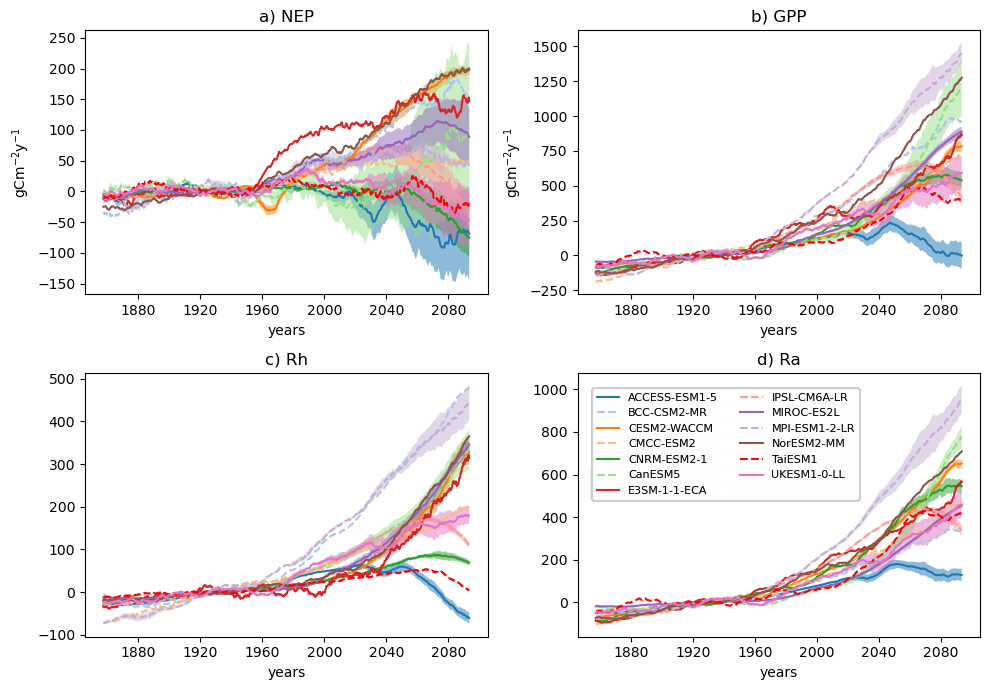

In [36]:
## ======== MULTIPLE Plots ======= ##
width_inch = 10; height_inch = 7


titles = ["a) NEP", "b) GPP", "c) Rh", "d) Ra"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(width_inch, height_inch))
axs = axs.ravel()

for t, ax in enumerate(trends):
    axs[t].set_prop_cycle(color=[
                                '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
                                '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#ff000d',
                                '#e377c2' ],
                        linestyle = ["-","--","-","--","-","--","-","--","-","--","-","--","-"])

    for i, item in enumerate(amz_gpp_trend_mean):
        axs[t].plot(trends[t][i]["time"], trends[t][i].rolling(time = 60, center = True).mean(), )  # fill with colorlabels =files_list)
        axs[t].fill_between(trends[t][i]["time"],
                 trends[t][i].rolling(time = 60, center = True).mean() - trends_std[t][i].rolling(time = 60, center = True).mean(),
                 trends[t][i].rolling(time = 60, center = True).mean() + trends_std[t][i].rolling(time = 60, center = True).mean(), alpha = 0.5,  label='_nolegend_')

        # axs[0].set_ylim(-220, 220)
        axs[0].set_ylabel("gCm$^{-2}$y$^{-1}$")
        axs[t].set_xlabel("years")
        axs[t].set_title(titles[t])

        # axs[1].set_ylim(-80, 20)
        axs[1].set_ylabel("gCm$^{-2}$y$^{-1}$")

        fig.legend(sorted(set(esm)), loc='lower right',bbox_to_anchor=(0.87, 0.27), fontsize=8, ncol= 2)

        output_file = os.path.join(out_path, "Amazon Basin trends".replace('/','_')) + "Carbon Fluxes.png"


fig.tight_layout()
# fig.savefig(output_file, bbox_inches='tight')